In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator , TransformerMixin,clone
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.model_selection import GridSearchCV, cross_val_score , cross_val_predict , cross_validate,train_test_split,StratifiedKFold,ShuffleSplit
from sklearn.metrics import classification_report , classification,accuracy_score ,roc_auc_score
import os 
import matplotlib

In [2]:
%matplotlib inline

In [3]:
os.path.join(os.getcwd() ,'images', '7_Ensemble_Learning')

'/Users/hitulshah/images/7_Ensemble_Learning'

In [4]:
# Lodaing moon datasets here to ensemble different algorithms
from sklearn.datasets import make_moons, 
data, target = make_moons(n_samples= 10000, noise= 0.4)

In [5]:
x_train , x_test , y_train , y_test = train_test_split(data, target, test_size = 0.3)

# Hard Voting

In [34]:
# Loading different algorithms to ensemble 

from sklearn.ensemble import RandomForestClassifier , ExtraTreesClassifier , VotingClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier 

In [7]:
#Comparing Different Model's Accuracies
RF = RandomForestClassifier(random_state= 42)
LR = LogisticRegression(random_state= 42)
SV = SVC(random_state= 42)

#Combining All algorithms into one
voting_clf = VotingClassifier(
                            estimators = [('log_reg_clf', LR),('rf_clf', RF), ('svm_clf', SV)],voting = 'hard')

for model in (RF, LR, SV, voting_clf):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print(model.__class__.__name__, accuracy_score(y_test, y_pred))

RandomForestClassifier 0.8336666666666667
LogisticRegression 0.8306666666666667
SVC 0.8553333333333333
VotingClassifier 0.8513333333333334


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


As we can see here vvoting classifier is performing better than majority of classifier (except SVM) 

# Soft Voting

In [8]:
#Comparing Different Model's Accuracies
RF_soft = RandomForestClassifier(random_state= 42)
LR_soft = LogisticRegression(random_state= 42)
#All models are unchanged except Support Vector Machine. Since support vector machine has no proba_func, we have to 
#mention SVM to calculate probability at the time of calling
SV_soft = SVC(probability= True , random_state= 42)

#Combining All algorithms into one
voting_clf = VotingClassifier(
                            estimators = [('log_reg_clf', LR_soft), ('svm_clf', SV_soft),('rf_clf', RF_soft)],voting = 'soft')

for model in (RF_soft, LR_soft, SV_soft, voting_clf):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print(model.__class__.__name__, accuracy_score(y_test, y_pred))

RandomForestClassifier 0.8336666666666667
LogisticRegression 0.8306666666666667
SVC 0.8553333333333333
VotingClassifier 0.8523333333333334


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In most of the cases, the soft margin is better than hard margin models since it takes an average of the probability of instance coming in that class.  So, the higher probability will get the higher weight

# Bagging

Sampling of instances with replacement. Binomial distribution 

In [9]:
from sklearn.ensemble import BaggingClassifier 

In [10]:
bag = BaggingClassifier(DecisionTreeClassifier() , n_estimators= 500 , max_samples= 100 ,bootstrap= True , n_jobs= -1 )

In [11]:
bag.fit(x_train , y_train)
y_pred = bag.predict(x_test)
print(bag.__class__.__name__ , accuracy_score(y_test, y_pred))

BaggingClassifier 0.8516666666666667


In [12]:
def plot_data(x, y): 
    plt.plot(x[:, 0][y == 0], x[:,1][y == 0], 'bs')
    plt.plot(x[:, 0][y == 1], x[:,1][y == 1], 'g^')
    plt.plot(x[:, 0][y == 2], x[:,1][y == 2], 'r.')
    plt.axis([x[:, 0].min(),x[:, 0].max(),x[:, 1].min(),x[:, 1].max()])
    plt.grid(True)
    plt.xlabel(r'$X1$' , fontsize = 15)
    plt.ylabel(r'$Y1$', fontsize = 15, rotation = 0)

In [88]:
def plot_density_fun(x, y , model):
    h = 0.02 #stepsize in mesh 
    x0 = np.arange(x[:, 0].min() - 0.5, x[:, 0].max() + 0.5 , h)
    x1 = np.arange(x[: , 1].min() - 0.5, x[:, 1].max() + 0.5 , h) 
    xx, yy = np.meshgrid(x0, x1)
    X = np.c_[xx.ravel(), yy.ravel()]
    model.fit(x, y)
    try:
        y_pred = model.predict_proba(X)[:, 1].reshape(xx.shape)
    except: 
        y_pred = model.predict(X).ravel().reshape(xx.shape)
    plt.contourf(xx, yy , y_pred, alpha= 0.2)
    #plt.contourf(xx,yy, y_decision_fun)

#We are going to compare it against decision tree decision 

In [14]:
DT = DecisionTreeClassifier(random_state= 42)


Text(0.5,1,'Decision Tree')

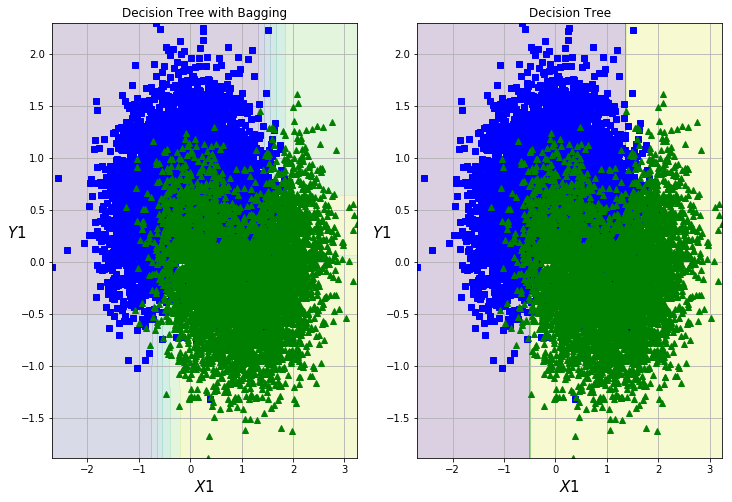

In [89]:
plt.figure(figsize = (12, 8))
plt.subplot(121)
plot_data(data, target)
plot_density_fun(data , target, bag)
plt.title('Decision Tree with Bagging')
plt.subplot(122)
plot_data(data, target)
plot_density_fun(data , target, DT)
plt.title('Decision Tree')

Advantages of using bagging/pasting are that it makes training data in each model independent. So, all models become independent and do not make the same mistakes

One of the disadvantages of bagging is that it trades bias over variance. Because of that sometimes It overfits the data. Below is a way to find whether it is overfitting or not. 

In [16]:
trainin_error = []
testing_error = []
bag = BaggingClassifier(DecisionTreeClassifier() , n_estimators= 500  ,bootstrap= True , n_jobs= -1 )
for m in range(1 , 100): 
    bag_model = clone(bag)
    bag_model.fit(x_train[:m], y_train[:m])
    y_val = bag_model.predict(x_train)
    val_acc = accuracy_score(y_train,y_val)
    trainin_error.append(1- val_acc)
    y_pred = bag_model.predict(x_test)
    test_acc = accuracy_score(y_test, y_pred)
    testing_error.append(1 - test_acc)

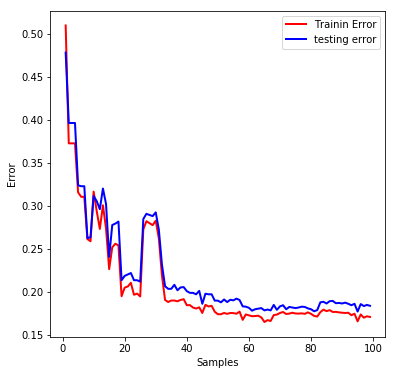

In [17]:
plt.figure(figsize = (6,6))
plt.plot(range(1,100), trainin_error, 'r-', lw = 2, label = 'Trainin Error')
plt.plot(range(1,100), testing_error,'b-', lw = 2, label = 'testing error')
plt.xlabel('Samples')
plt.ylabel('Error')
plt.legend()

# Pasting

It is a without replacement sampling method. In sklearn, pasting is called by Baggingclisifier itself. The only change is that instead of using bootstrap True, it requires False 

In [18]:
pasting = BaggingClassifier(DecisionTreeClassifier() , n_estimators= 500 , max_samples= 100 ,bootstrap= False , n_jobs= -1 )

In [19]:
pasting.fit(x_train , y_train)
y_pred = pasting.predict(x_test)
print(bag.__class__.__name__ , accuracy_score(y_test, y_pred))

BaggingClassifier 0.8563333333333333


# Random Forest

In [20]:
RF = RandomForestClassifier(n_estimators= 500 , bootstrap= True , random_state= 42, max_depth= 2)
RF.fit(x_train , y_train)
y_pred = RF.predict(x_test)
accuracy_score(y_test, y_pred) 

0.8546666666666667

Lets check decison boundry of Random forest 

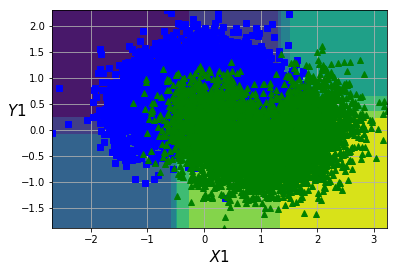

In [21]:
RF = RandomForestClassifier(n_estimators= 500 , bootstrap= True , random_state= 42, max_depth= 2)
plot_data(data, target)
plot_density_fun(data , target, RF)

In [32]:
RF.feature_importances_

array([0.4631065, 0.5368935])

In [29]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [38]:
mnist_data = mnist.data
mnist_target = mnist.target
mnist_col_names = mnist.COL_NAMES

In [39]:
m_x_train,m_x_test , m_y_train, m_y_test = train_test_split(mnist_data, mnist_target , test_size = 0.3)

In [44]:
m_RF = RandomForestClassifier(n_estimators= 50 , bootstrap= True , random_state= 42, max_depth= 2)

In [45]:
model_rf = m_RF.fit(m_x_train , m_y_train)
m_y_test_pred = model_rf.predict(m_x_test)
accuracy_score(m_y_test, m_y_test_pred)

0.6294761904761905

In [52]:
image = model_rf.feature_importances_.reshape(28,28)

[Text(1,0,'Not important'), Text(1,0,'Important')]

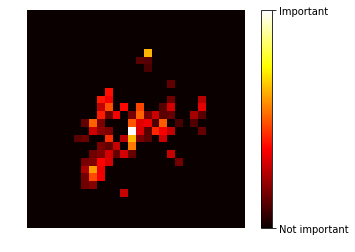

In [73]:
plt.imshow(image ,cmap= matplotlib.cm.hot,interpolation= 'nearest')
plt.axis('off')
cb = plt.colorbar(ticks = [model_rf.feature_importances_.min(), model_rf.feature_importances_.max()])
cb.ax.set_yticklabels(['Not important', 'Important'])

# Out of bag Evaluation 

Since we are training our model on samples of the total data, then we can evaluate that model on rest of the data.
Each model in Bagging weak classifier will have independent data than other models and will also have different out of bag data.
Because of this out of bag data, we dont need to split data for validation at all.

This feature is set on by using oob_score = True in models' parameter

In [22]:
bag = BaggingClassifier(DecisionTreeClassifier() , n_estimators= 500 
                        , max_samples= 100 ,bootstrap= True ,oob_score = True, n_jobs= -1 )

In [23]:
bag.fit(x_train , y_train)
val_score = bag.oob_score_
print(val_score)

0.8598571428571429


In [24]:
bag.oob_decision_function_

array([[0.07692308, 0.92307692],
       [0.56646217, 0.43353783],
       [0.76565657, 0.23434343],
       ...,
       [0.88617886, 0.11382114],
       [0.1300813 , 0.8699187 ],
       [0.09368635, 0.90631365]])

Try to make Adaboost algorithm 

class Adaboost():
    def __init__ (self, model, n_estimator):
        self.model = model 
        self.n_estimator = n_estimator
        self.weight = []
        self.pred = []
        
    def fit(self, X, y ):
        self.weight_ = [1 / len(X)] * len(X)
        r = 1 / len(x)
        for i in range(self.n_estimator):
            alpha = np.log((1 - self.weight_) / self.weight_)
            self.model.fit(X,y)
            y_pred = self.model.predict(y)
            self.pred.append(y_pred * alpha)
            for i in range(0 , len(X)):
                if y_pred[i] != y[i]:
                    self.weight[i] = (self.weight[i] * np.exp(alpha)) 
                    
    
                

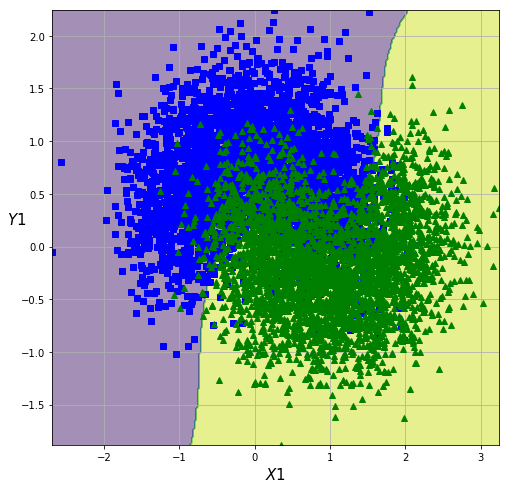

In [98]:
m = len(x_train)
weight = np.ones(m)
learning_rate = 0.5
svm_clf = SVC(kernel= 'rbf', random_state = 42)
plt.figure(figsize = (8,8))
#plt.subplot(121)
plot_data(x_train , y_train)
for i in range(3):
    svm_clf.fit(x_train, y_train ,sample_weight= weight)
    y_pred = svm_clf.predict(x_train)
    weight[y_train != y_pred] *= (1 + learning_rate)
    plot_density_fun(x_train, y_train , svm_clf)

# Excercise

In [3]:
from sklearn.datasets import fetch_mldata 

In [4]:
mnist = fetch_mldata('MNIST original')

In [13]:
data = mnist['data'] 
target = mnist['target'] 
COL_Name = mnist['COL_NAMES']

In [24]:
shuffle = ShuffleSplit(n_splits = 1, random_state = 42, test_size= 20000)

In [33]:
for  train_index , test_index in shuffle.split(data, target): 
    x_train, y_train  = data[train_index], target[train_index]
    split = int(len(test_index) / 2) 
    x_val_test, y_val_test = data[test_index] , target[test_index]
    x_val,y_val = x_val_test[:split], y_val_test[:split]
    x_test, y_test = x_val_test[split:], y_val_test[split:]
del x_val_test, y_val_test

In [37]:
DT = DecisionTreeClassifier(random_state = 42)
RF = RandomForestClassifier(random_state = 42 )
SV = SVC(random_state= 42, probability= True)

In [ ]:
for model in DT,RF,: 
    model_clf = clone(model)
    model_clf.fit(x_train , y_train)
    y_val_pred = model_clf.predict(x_val)
    y_test_pred = model_clg.predict(x_test)
    print(model_clf.__class__.__name__,'Validation Accuracy:' ,accuracy_score(y_val, y_val_pred)
          ,'Test Accuracy: ' ,accuracy_score(y_test, y_test_pred)) 
    

<class 'sklearn.tree.tree.DecisionTreeClassifier'> __main__ 0.8693
<class 'sklearn.ensemble.forest.RandomForestClassifier'> __main__ 0.9444


In [ ]:
VotingClassofier([])